In [1]:
from typing import List

import numpy as np
import csv
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

In [15]:
alphas = [0.25, 0.5, 0.75, 1.0]
# seeds = [12, 42, 69, 10420]
# seeds = [128, 4242, 1234, 48]
seeds = [12, 42, 69, 10420, 128, 4242, 1234, 48]

In [3]:
def interpolate(x, y, at):
    return interp1d(x, y, kind="linear", fill_value=(np.min(y), np.max(y)), bounds_error=False)(at)

In [4]:
def plot(all_evals: List, label: str, smooth_factor=2, color="b", max_samples=None, eval_rate=None):
    intervals = np.arange(0, max_samples, eval_rate)
    all_evals = np.stack([interpolate(np.array(evals)[:,0],np.array(evals)[:,1],intervals) for evals in all_evals])
    mean_reward = all_evals.mean(axis=0)
    sem_reward = sem(all_evals, axis=0)
    ci_95 = 1.96 * sem_reward

    mean_reward_smooth = gaussian_filter1d(mean_reward, smooth_factor)
    ci_95_smooth = gaussian_filter1d(ci_95, smooth_factor)

    plt.plot(intervals, mean_reward_smooth, label=label, color=color)
    plt.fill_between(intervals, mean_reward_smooth - ci_95_smooth, mean_reward_smooth + ci_95_smooth, color=color, alpha=0.2)

In [5]:
def load_evals(path):
    with open(path, newline='') as file:
        rd = csv.reader(file)
        return list(map(lambda x: [float(y) for y in x], rd))

(4, 8, 200, 2)


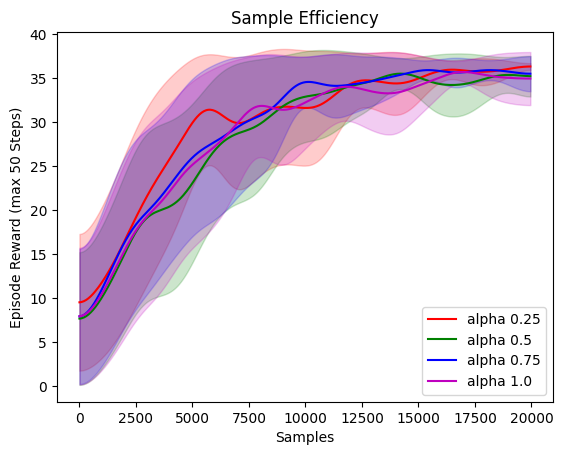

In [20]:
path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / "poster_mal_agent_reward" / "sample_efficiency" / "alpha"
colors = ['r', 'g', 'b', 'm']
paths = [[f"{path}_{alpha}_seed_{seed}" for seed in seeds] for alpha in alphas]
evals = np.array([[load_evals(p) for p in a] for a in paths])
print(evals.shape)
max_samples = np.max(evals[:, :, :, 0])

smooth_factor = 15.0
for e, a, c in zip(evals, alphas, colors):
    plot(e, f"alpha {a}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c)
    
plt.title("Sample Efficiency")
plt.ylabel("Episode Reward (max 50 Steps)")
plt.xlabel("Samples")
plt.legend()

# This part is just for creating data

In [14]:
from stackelberg_mbrl.experiments.experiment_config import ExperimentConfig, EnvConfig, PolicyConfig, WorldModelConfig, LoadPolicy, LeaderEnvConfig, SampleEfficiency
from stackelberg_mbrl.train_mal import train_contextualized_MAL
from itertools import product

for alpha, seed in product(alphas, seeds):
    config = ExperimentConfig(
        experiment_name="poster_mal_agent_reward",
        env_config=EnvConfig(
            env_true_id="simple_mdp_2",
            env_eval_id="simple_mdp_2",
            max_episode_steps=50
        ),
        policy_config=LoadPolicy(
            path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
        ),
        # policy_config=PolicyConfig(
        #     pretrain_iterations=1,
        #     samples_per_training_iteration=1_000_000,
        #     model_save_name="policy_simple_mdp_2",
        # ),
        leader_env_config=LeaderEnvConfig(
            env_reward_weight=alpha
        ),
        sample_efficiency=SampleEfficiency(
            sample_eval_rate=100,
            n_eval_episodes=30,
            max_samples=20_000,
            log_save_name=f"alpha_{alpha}_seed_{seed}"
        ),
        world_model_config=WorldModelConfig(
            total_training_steps=250_000,
            # total_training_steps=1_000,
            model_save_name="simple_mdp_2",
        ),
        seed=seed
    )

    train_contextualized_MAL(config)

Loading policy model from file.


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_128.
Model reward: (8.735840382054448, 0.2691802925863717)
Avg Policy Reward on learned model:   6.200 ± 6.339
Avg Policy Reward on real env:   37.010 ± 0.367
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_4242.
Model reward: (9.149336875882, 0.1105090812779963)
Avg Policy Reward on learned model:   5.600 ± 6.369
Avg Policy Reward on real env:   36.530 ± 1.100
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_1234.
Model reward: (8.915655490662903, 0.405802961596174)
Avg Policy Reward on learned model:   16.695 ± 12.033
Avg Policy Reward on real env:   36.610 ± 0.862
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_48.
Model reward: (8.968574290070682, 0.34306372394785284)
Avg Policy Reward on learned model:   30.585 ± 10.147
Avg Policy Reward on real env:   36.210 ± 1.015
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_128.
Model reward: (18.339155594073237, 0.1632539741596173)
Avg Policy Reward on learned model:   3.885 ± 3.338
Avg Policy Reward on real env:   36.610 ± 0.862
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_4242.
Model reward: (18.4143049441278, 0.20258385663661244)
Avg Policy Reward on learned model:   15.390 ± 8.369
Avg Policy Reward on real env:   36.050 ± 1.442
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_1234.
Model reward: (18.15359108764678, 0.4760580555518423)
Avg Policy Reward on learned model:   4.090 ± 6.365
Avg Policy Reward on real env:   36.450 ± 1.131
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_48.
Model reward: (18.270254351198673, 0.3614856213258406)
Avg Policy Reward on learned model:   7.185 ± 8.692
Avg Policy Reward on real env:   37.090 ± 0.320
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.75_seed_128.
Model reward: (27.264269734174015, 0.6355320629369121)
Avg Policy Reward on learned model:   6.695 ± 6.416
Avg Policy Reward on real env:   36.370 ± 0.835
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.75_seed_4242.
Model reward: (27.20624110624194, 0.42584306763666857)
Avg Policy Reward on learned model:   10.430 ± 4.293
Avg Policy Reward on real env:   35.730 ± 1.406
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.75_seed_1234.
Model reward: (27.601583551615477, 0.3022655136883259)
Avg Policy Reward on learned model:   14.755 ± 4.567
Avg Policy Reward on real env:   36.130 ± 1.197
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.75_seed_48.
Model reward: (27.02133310586214, 1.406294981719965)
Avg Policy Reward on learned model:   5.310 ± 3.751
Avg Policy Reward on real env:   36.850 ± 0.645
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_1.0_seed_128.
Model reward: (36.34499999918044, 0.8069851306757413)
Avg Policy Reward on learned model:   16.525 ± 7.090
Avg Policy Reward on real env:   35.650 ± 1.559
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_1.0_seed_4242.
Model reward: (36.26499999910593, 1.7765204771271315)
Avg Policy Reward on learned model:   5.125 ± 4.106
Avg Policy Reward on real env:   36.210 ± 1.861
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_1.0_seed_1234.
Model reward: (33.329999999329445, 9.65616901268499)
Avg Policy Reward on learned model:   7.480 ± 8.560
Avg Policy Reward on real env:   35.730 ± 1.695
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_1.0_seed_48.
Model reward: (36.60999999940395, 0.6974238316160343)
Avg Policy Reward on learned model:   6.745 ± 5.875
Avg Policy Reward on real env:   36.770 ± 0.816
